# Navigation: Banana Collector

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
import pickle
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

from collections import deque, defaultdict, namedtuple
from drlnd_dqn.agents import Agent
from drlnd_dqn.plot_utils import plot_final_results, TFColor
from unityagents import UnityEnvironment

%load_ext autoreload
%autoreload 2
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
episode = 0
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    episode = episode+1
    if done:                                       # exit loop if episode finished
        print(episode)
        break
    
print("Score: {}".format(score))

300
Score: 0.0


### 4. Train the Agents

We will now train an agent to solve the environment. Recall that the environment is considered solved when the agent gets an average score of +13 over 100 consecutive episodes.

In [6]:
# conditions for solving the environment
SCORE_WINDOW_SIZE = 100
MEAN_SCORE_WINDOW_TARGET = 13.0

We will train two types of agents - we use a Q-Learning algorithm for off-policy TD control using neural networks for function approximation.

The two agents we train are:
* **Deep Q-network agent**: which approximates a state-value function in a Q-Learning framework with a neural network. **Mnih et al. (2015)**
* **A Double Q-learning agent**: that utilises double estimation to counteract overestimation problems with traditional Q-learning. **van Hasselt et al. (2015)**

The behaviour policy that we will use during training is $\epsilon$-greedy with $\epsilon$ decayed from 1.0 to 0.01 at a decay rate of 0.995, and fixed at 0.01 thereafter. The plot below demonstrates how epsilon decays over the episodes.

Text(0.5, 1.0, 'Annealing of epsilon over episodes trained')

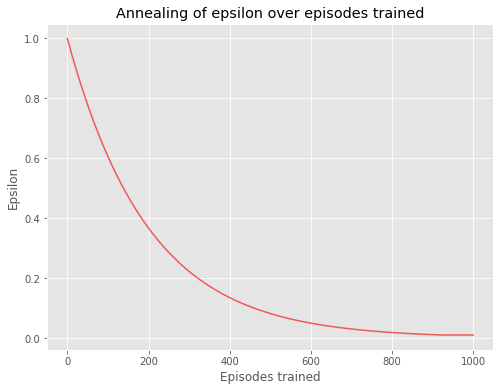

In [7]:
# Behavior policy
EPSILON_START=1.0
EPSILON_END=0.01
EPSILON_DECAY=0.995

eps = EPSILON_START
epsilons = [EPSILON_START]

for i in range(1000):
    eps = max(EPSILON_END, EPSILON_DECAY*eps)
    epsilons.append(eps)

plt.figure(figsize=(8,6))
plt.plot(epsilons, color=TFColor.red)
plt.xlabel('Episodes trained')
plt.ylabel('Epsilon')
plt.title('Annealing of epsilon over episodes trained')

In order to compare the performance of the two agents, we will train each agent 10 times with a different seed and compare the average performance.

In [8]:
# number of training runs with different random seeds
N_ITERATIONS = 10

# Creating a tuple to hold the results
Result = namedtuple('Result', 'scores solved_in policy_weights algorithm')

# Core training function
def train(agent, n_episodes=600, 
          eps_start=EPSILON_START, eps_end=EPSILON_END, eps_decay=EPSILON_DECAY,
          policy_weights='checkpoint.pth'):
    """Train an Agent.
    
    Params
    ======
        agent: an Agent object
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    solved = False
    scores = []                                            # list containing scores from each episode
    scores_window = deque(maxlen=SCORE_WINDOW_SIZE)        # last 100 scores
    eps = eps_start                                        # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if not solved and np.mean(scores_window)>=MEAN_SCORE_WINDOW_TARGET:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), policy_weights)
            episodes_solved_in = i_episode-100
            solved = True
        
    result = Result(scores=scores, 
                    solved_in=episodes_solved_in, 
                    policy_weights=policy_weights, 
                    algorithm=agent.algorithm)
            
    return result

Below, we use the training method to train multiple agents with different random seeds.

In [9]:
# load the results of any agents that have been trained so far
if os.path.exists('./models/allresults.pkl'):
    with open('./models/allresults.pkl', 'rb') as f:
        allresults = pickle.load(f)

# train deep-Q network agents with different seeds
DQN_results = []
for i in range(N_ITERATIONS):
    # only train if checkpoint for seed does not exist
    if not os.path.exists(f'./models/DQN_checkpoint_{i}.pth'):
        DQNAgent = Agent(state_size=state_size, action_size=action_size, seed=i, double=False)
        result = train(agent=DQNAgent, policy_weights=f'./models/DQN_checkpoint_{i}.pth')
        DQN_results.append(result)

# train double deep-Q network agents with different seeds
DDQN_results = []
for i in range(N_ITERATIONS):
    # only train if checkpoint for seed does not exist
    if not os.path.exists(f'./models/DDQN_checkpoint_{i}.pth'):
        DDQNAgent = Agent(state_size=state_size, action_size=action_size, seed=i, double=True)
        result = train(agent=DDQNAgent, policy_weights=f'./models/DDQN_checkpoint_{i}.pth')
        DDQN_results.append(result)

# append the results of any newly trained agents
if os.path.exists('./models/allresults.pkl'):
    allresults = allresults + DQN_results + DDQN_results
else:
    allresults = DQN_results + DDQN_results

# pickle and save the results
with open('./models/allresults.pkl', 'wb') as f:
    pickle.dump(allresults, f)

### 5. Results

The plot below shows the training curves tracking the agent’s average score. We use a slightly modified version of the [plotting approach](https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb) from the `baselines` library to succinctly show results of the multiple agent training runs.

Each agent is shown in a distinct color. Each point is the average (smoothed) score achieved per episode after the agent is run. The smoothing is perfromed over a 10 episode smoothing window. The lighter shade around the scores line shows the standard deviation of data, and darker shade - error in estimate of the mean (i.e. standard deviation divided by square root of number of seeds). The solid vertical line shows the average (over multiple training runs) episodes the environment was solved in. The shaded area around the line shows the standard deviation of this data.

We note the following from the plot:
* The training of both the DQN agent and the Double-DQN agent is stable as illustrated by the increasing average score over the training timeline
* Both agents are able to solve the environment in under 600 episodes - typically in range of ~375-425 episodes.
* On average, the Double-DQN seems to perform marginally better than DQN as evidenced by the fewer average number of episodes it takes for Double-DQN to solve the environment - 396 for DDQN vs 403 for DQN. However, there is no clear winner between the two (as demonstrated by the overlap between the standard deviation bands).

(<Figure size 576x432 with 1 Axes>,
 array([[<AxesSubplot:xlabel='Number of episodes trained', ylabel='Average score per episode'>]],
       dtype=object))

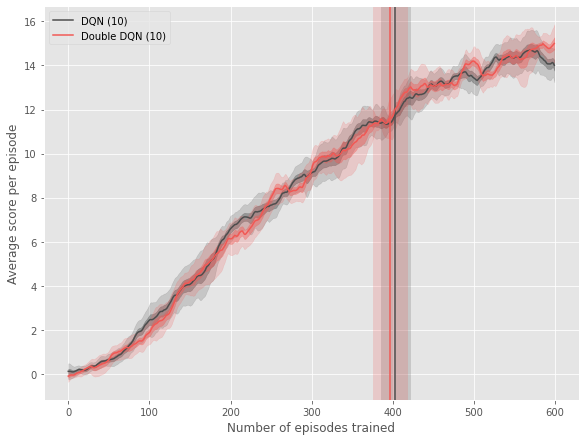

In [10]:
plot_final_results(allresults, 
                   figsize=(8, 6),
                   group_fn=lambda x:x.algorithm, 
                   shaded_err=True,
                   shaded_std=True,
                   average_group=True,
                   xlabel='Number of episodes trained',
                   ylabel='Average score per episode'
                  )

Save the weights of the best agent - we designate the agent that achieved the score of +13 in the fewest number of episodes as the best performing agent.

In [11]:
best_result = min(allresults, key = lambda t: t.solved_in)
print(f"Best performing agent is based on {best_result.algorithm}; policy file is at: {best_result.policy_weights}")

# save file as ./models/checkpoint.pth
shutil.copy(best_result.policy_weights, './models/checkpoint.pth')

Best performing agent is based on Double DQN; policy file is at: ./models/DDQN_checkpoint_7.pth


'./models/checkpoint.pth'

Finally, we close the environment.

In [12]:
env.close()

#fin